In [3]:
from datasets import load_dataset
import json
import torch
from transformers import AutoModelForCausalLM
from transformers import AutoTokenizer
from tqdm import tqdm
from vllm import LLM, SamplingParams
import os
from dotenv import load_dotenv

load_dotenv()


False

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [9]:
model_name = "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
model = model.to(device) 

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/680 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-000002.safetensors:   0%|          | 0.00/6.62G [00:00<?, ?B/s]

model-00001-of-000002.safetensors:   0%|          | 0.00/8.61G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

In [10]:
new_system_prompt = "Please solve the problem step by step (separate steps with double newlines), but keep it short and put your final answer (do not include any other text or units) within \\boxed{}."

In [11]:
def infer(input, temperature=0.7, max_new_tokens=256, top_p=0.9, top_k=50, do_sample=True, system_prompt=None):
    if isinstance(input, str):
        if system_prompt is None:
            messages = [{"role": "user", "content": input}]
        else:
            messages = [{"role": "system", "content": system_prompt}, {"role": "user", "content": input}]
    elif isinstance(input, list):
        messages = input
    else:
        raise ValueError("input phải là string hoặc list of dict")
    
    inputs = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        tokenize=True,
        return_dict=True,
        return_tensors="pt",
    ).to(device)
    
    outputs = model.generate(   
        **inputs,
        max_new_tokens=max_new_tokens,
        temperature=temperature,
        top_p=top_p,
        top_k=top_k,
        do_sample=do_sample,
    )
    
    len_inputs = inputs['input_ids'].shape[-1]
    response = tokenizer.decode(outputs[0][len_inputs:], skip_special_tokens=True)
    
    return response

def infer_batch(messages_list, temperature=0.7, max_new_tokens=256, top_p=0.9, top_k=50, do_sample=True):
    all_messages = []
    for item in messages_list:
        if isinstance(item, str):
            all_messages.append([{"role": "user", "content": item}])
        elif isinstance(item, list):
            all_messages.append(item)
        else:
            raise ValueError("Mỗi phần tử phải là string hoặc list of dict")
    
    inputs = tokenizer.apply_chat_template(
        all_messages,
        add_generation_prompt=True,
        tokenize=True,
        return_dict=True,
        return_tensors="pt",
        padding=True,
    ).to(device)
    
    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        temperature=temperature,
        top_p=top_p,
        top_k=top_k,
        do_sample=do_sample,
    )
    
    responses = []
    for i in range(len(outputs)):
        input_ids = inputs['input_ids'][i]
        non_pad_length = (input_ids != tokenizer.pad_token_id).sum().item()
        
        response = tokenizer.decode(
            outputs[i][non_pad_length:], 
            skip_special_tokens=True
        )
        responses.append(response)
    
    return responses

In [12]:
sample_question = """
Every morning Aya goes for a $9$-kilometer-long walk and stops at a coffee shop afterwards. When she walks at a constant speed of $s$ kilometers per hour, the walk takes her 4 hours, including $t$ minutes spent in the coffee shop. When she walks $s+2$ kilometers per hour, the walk takes her 2 hours and 24 minutes, including $t$ minutes spent in the coffee shop. Suppose Aya walks at $s+\frac{1}{2}$ kilometers per hour. Find the number of minutes the walk takes her, including the $t$ minutes spent in the coffee shop.
"""

In [13]:
print(infer(sample_question, 
                system_prompt=None,
                max_new_tokens=4096,
                temperature=0.0,
                do_sample=False
            )
)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Okay, so I have this problem where Aya goes for a 9-kilometer walk every morning and then stops at a coffee shop. The problem gives me two different scenarios about her walking speed and the time it takes, including the time she spends in the coffee shop. I need to find out how long it takes her when she walks at a speed of s + 1/2 kilometers per hour, including the coffee shop time.

Let me try to break this down step by step.

First, let's parse the information given:

1. When Aya walks at a constant speed of s km/h, the entire trip (walk + coffee shop) takes 4 hours.
2. When she walks at s + 2 km/h, the entire trip takes 2 hours and 24 minutes.
3. In both cases, the time spent in the coffee shop is t minutes.
4. We need to find the total time when she walks at s + 1/2 km/h, including the coffee shop time.

So, the key here is that the coffee shop time, t, is the same in both scenarios. The difference is in her walking speed and the total time taken.

Let me denote the time she spend

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Optional
import seaborn as sns


def calculate_token_entropy_transformers(
    scores: torch.Tensor,
    tokenizer,
    output_tokens: List[str],
    top_k_display: int = 5
) -> List[Dict]:
    """
    Tính EXACT entropy over full vocab từ transformers scores (GPU-optimized)
    
    NOTE: Hàm này tính exact entropy, KHÔNG approximate như vLLM version
    
    Args:
        scores: Stacked scores từ outputs.scores, shape (T, B, V)
        tokenizer: Tokenizer để decode tokens
        output_tokens: List of decoded output tokens
        top_k_display: Số lượng top alternatives để hiển thị (default 5)
        
    Returns:
        List of dicts chứa entropy info cho mỗi token
    """
    # ===== 1) Prepare logits =====
    if scores.dim() == 3:
        logits = scores[:, 0, :]  # (T, V) - assume batch=1
    else:
        logits = scores  # Already (T, V)
    
    T, V = logits.shape
    
    # ===== 2) Exact entropy over full vocab (GPU vectorized) =====
    # H = logZ - sum(p * logits)
    # Using the formula: H = -sum(p * log(p)) = -sum(p * (log(p_i) - log(Z)))
    #                      = log(Z) - sum(p * log(p_i))
    logZ = torch.logsumexp(logits, dim=-1)  # (T,)
    probs = torch.softmax(logits, dim=-1)   # (T, V)
    entropy = logZ - (probs * logits).sum(dim=-1)  # (T,)
    
    # ===== 3) Top-k alternatives for display (GPU) =====
    topk_logits, topk_indices = torch.topk(logits, k=top_k_display, dim=-1)  # (T, k)
    
    # logprob of topk according to full vocab softmax:
    # log p(token_i) = logit_i - logZ
    topk_logprobs = topk_logits - logZ.unsqueeze(-1)  # (T, k)
    
    # topk probs for display
    topk_probs = torch.exp(topk_logprobs)  # (T, k)
    
    # ===== 4) Move only small tensors to CPU for python dict =====
    entropy_cpu = entropy.detach().cpu().tolist()
    topk_indices_cpu = topk_indices.detach().cpu().tolist()
    topk_logprobs_cpu = topk_logprobs.detach().cpu().tolist()
    topk_probs_cpu = topk_probs.detach().cpu().tolist()
    
    # ===== 5) Build entropies list (loop only for decoding tokens & packaging) =====
    entropies = []
    
    for pos in range(T):
        topk_tokens = [tokenizer.decode([idx]) for idx in topk_indices_cpu[pos]]
        
        entropies.append({
            "position": pos,
            "token": output_tokens[pos] if pos < len(output_tokens) else "",
            "entropy": entropy_cpu[pos],
            "top_alternatives": list(zip(topk_tokens, topk_logprobs_cpu[pos])),  # (token, logprob)
            "top_probs": topk_probs_cpu[pos],  # only top-k probs for display
            "num_tokens_used": V,  # exact over full vocab
            "prob_coverage": 1.0   # exact coverage
        })
    
    return entropies


In [16]:
def visualize_entropy(entropies: List[Dict], figsize: Tuple[int, int] = (20, 8), 
                     title: str = "Token Entropy Analysis"):
    """
    Visualize entropy cho mỗi token position
    
    Args:
        entropies: Output từ calculate_token_entropy()
        figsize: Figure size
        title: Plot title
    """
    fig, axes = plt.subplots(2, 1, figsize=figsize)
    
    positions = [e['position'] for e in entropies]
    entropy_values = [e['entropy'] for e in entropies]
    tokens = [e['token'] for e in entropies]
    
    # Plot 1: Entropy line plot với tokens
    ax1 = axes[0]
    ax1.plot(positions, entropy_values, 'b-', linewidth=2, marker='o', markersize=4)
    ax1.set_xlabel('Token Position', fontsize=12)
    ax1.set_ylabel('Entropy', fontsize=12)
    ax1.set_title(f'{title} - Entropy per Token', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Highlight high entropy tokens
    high_entropy_threshold = np.mean(entropy_values) + np.std(entropy_values)
    high_entropy_mask = np.array(entropy_values) > high_entropy_threshold
    high_entropy_positions = np.array(positions)[high_entropy_mask]
    high_entropy_values = np.array(entropy_values)[high_entropy_mask]
    ax1.scatter(high_entropy_positions, high_entropy_values, 
                color='red', s=100, zorder=5, label='High Entropy')
    ax1.legend()
    
    # Plot 2: Heatmap of top-k alternatives probabilities
    ax2 = axes[1]
    
    # Prepare data for heatmap (lấy top-k positions để hiển thị)
    n_display = min(50, len(entropies))  # Display first 50 tokens
    display_entropies = entropies[:n_display]
    
    # Create matrix: rows = positions, cols = top-k alternatives
    max_k = max(len(e['top_probs']) for e in display_entropies)
    prob_matrix = np.zeros((n_display, max_k))
    
    for i, e in enumerate(display_entropies):
        probs = e['top_probs']
        prob_matrix[i, :len(probs)] = probs
    
    # Heatmap
    im = ax2.imshow(prob_matrix.T, aspect='auto', cmap='YlOrRd', interpolation='nearest')
    ax2.set_xlabel('Token Position', fontsize=12)
    ax2.set_ylabel('Top-K Alternatives', fontsize=12)
    ax2.set_title('Probability Distribution (Top-K per Token)', fontsize=14, fontweight='bold')
    
    # Add colorbar
    plt.colorbar(im, ax=ax2, label='Probability')
    
    # Add text annotations for tokens on x-axis
    step = max(1, n_display // 20)  # Show every nth token
    ax2.set_xticks(range(0, n_display, step))
    ax2.set_xticklabels([display_entropies[i]['token'][:10] for i in range(0, n_display, step)], 
                        rotation=45, ha='right', fontsize=8)
    
    plt.tight_layout()
    return fig


In [17]:
def print_token_details(entropies: List[Dict], top_n: int = 10, 
                        sort_by: str = 'entropy'):
    """
    In chi tiết tokens với entropy cao nhất
    
    Args:
        entropies: Output từ calculate_token_entropy()
        top_n: Số lượng tokens để hiển thị
        sort_by: 'entropy' hoặc 'position'
    """
    # Sort by entropy (descending)
    if sort_by == 'entropy':
        sorted_entropies = sorted(entropies, key=lambda x: x['entropy'], reverse=True)
    else:
        sorted_entropies = entropies
    
    print(f"\n{'='*80}")
    print(f"Top {top_n} Tokens by Entropy")
    print(f"{'='*80}\n")
    
    for i, e in enumerate(sorted_entropies[:top_n], 1):
        print(f"{i}. Position {e['position']}: '{repr(e['token'])}' (Entropy: {e['entropy']:.4f})")
        print(f"   Top alternatives:") 
        for j, (token, logprob) in enumerate(e['top_alternatives'], 1):
            prob = e['top_probs'][j-1]
            print(f"      {j}. '{token}' (prob: {prob:.4f}, logprob: {logprob:.4f})")
        print()


In [31]:
def visualize_attention(
    attention_weights: tuple,  # From outputs.attentions
    layers_heads: List[Tuple[int, int]],  # [(layer_idx, head_idx), ...]
    tokens: Optional[List[str]] = None,
    figsize_per_plot: Tuple[int, int] = (10, 8),
    max_tokens_display: int = 50,
    start_idx: int = 0,
    end_idx: int = None,
):
    """
    Visualize attention scores cho nhiều layers và heads
    
    Args:
        attention_weights: Tuple of attention tensors từ model output
                          Shape: tuple of (batch, num_heads, seq_len, seq_len)
        layers_heads: List of tuples (layer_number, head_index)
                     Ví dụ: [(0, 0), (5, 3), (11, 7)]
        tokens: Optional list of decoded tokens để label axes
        figsize_per_plot: Size cho mỗi subplot
        max_tokens_display: Số tokens tối đa để hiển thị (truncate nếu quá dài)
    
    Returns:
        fig: matplotlib figure object
    """
    n_plots = len(layers_heads)
    
    # Calculate grid layout
    n_cols = min(3, n_plots)  # Max 3 columns
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(
        n_rows, n_cols, 
        figsize=(figsize_per_plot[0] * n_cols, figsize_per_plot[1] * n_rows)
    )
    
    # Handle single plot case
    if n_plots == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for idx, (layer_idx, head_idx) in enumerate(layers_heads):
        ax = axes[idx]
        
        # Get attention weights for this layer and head
        # attention_weights[layer_idx] shape: (batch, num_heads, seq_len, seq_len)
        attn = attention_weights[layer_idx][0, head_idx].detach().cpu().numpy()
        
        # Truncate if too long
        seq_len = min(attn.shape[0], max_tokens_display)
        attn = attn[:seq_len, :seq_len]
        
        # Plot heatmap
        im = ax.imshow(attn, cmap='viridis', aspect='auto', interpolation='nearest')
        
        # Labels
        ax.set_title(f'Layer {layer_idx}, Head {head_idx}', 
                    fontsize=12, fontweight='bold')
        ax.set_xlabel('Key Position', fontsize=10)
        ax.set_ylabel('Query Position', fontsize=10)
        
        # Add colorbar
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
        # Add token labels if provided
        if tokens is not None:
            if end_idx is not None:
                display_tokens = tokens[start_idx:end_idx]
            else:
                display_tokens = tokens[start_idx:seq_len]
            # Show every nth token to avoid crowding
            step = max(1, len(display_tokens) // 15)
            tick_positions = list(range(0, len(display_tokens), step))
            tick_labels = [display_tokens[i][:15] for i in tick_positions]
            
            ax.set_xticks(tick_positions)
            ax.set_xticklabels(tick_labels, rotation=45, ha='right', fontsize=7)
            ax.set_yticks(tick_positions)
            ax.set_yticklabels(tick_labels, fontsize=7)
    
    # Hide empty subplots
    for idx in range(n_plots, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    return fig


In [19]:
def visualize_attention_patterns(
    attention_weights: tuple,
    layers_heads: List[Tuple[int, int]],
    tokens: Optional[List[str]] = None,
    pattern_type: str = 'mean',  # 'mean', 'max', 'specific_token'
    token_idx: Optional[int] = None,
    figsize: Tuple[int, int] = (15, 5)
):
    """
    Visualize specific attention patterns across layers/heads
    
    Args:
        attention_weights: Tuple of attention tensors
        layers_heads: List of (layer_idx, head_idx) tuples
        tokens: Optional list of tokens
        pattern_type: 'mean' (avg attention per position), 
                     'max' (max attention per position),
                     'specific_token' (attention from specific token)
        token_idx: Required if pattern_type='specific_token'
        figsize: Figure size
    """
    fig, axes = plt.subplots(1, len(layers_heads), figsize=figsize)
    
    if len(layers_heads) == 1:
        axes = [axes]
    
    for idx, (layer_idx, head_idx) in enumerate(layers_heads):
        ax = axes[idx]
        
        # Get attention weights
        attn = attention_weights[layer_idx][0, head_idx].detach().cpu().numpy()
        
        # Calculate pattern based on type
        if pattern_type == 'mean':
            pattern = attn.mean(axis=0)  # Average attention received by each position
            title = f'Mean Attention (L{layer_idx}H{head_idx})'
        elif pattern_type == 'max':
            pattern = attn.max(axis=0)  # Max attention received by each position
            title = f'Max Attention (L{layer_idx}H{head_idx})'
        elif pattern_type == 'specific_token' and token_idx is not None:
            pattern = attn[token_idx, :]  # Attention from specific token
            title = f'Attention from Token {token_idx} (L{layer_idx}H{head_idx})'
        else:
            raise ValueError("Invalid pattern_type or missing token_idx")
        
        # Plot
        positions = np.arange(len(pattern))
        ax.bar(positions, pattern, alpha=0.7)
        ax.set_title(title, fontsize=10, fontweight='bold')
        ax.set_xlabel('Token Position', fontsize=9)
        ax.set_ylabel('Attention Score', fontsize=9)
        ax.grid(True, alpha=0.3)
        
        # Add token labels if provided
        if tokens is not None:
            step = max(1, len(tokens) // 15)
            tick_positions = list(range(0, len(tokens), step))
            tick_labels = [tokens[i][:10] for i in tick_positions]
            ax.set_xticks(tick_positions)
            ax.set_xticklabels(tick_labels, rotation=45, ha='right', fontsize=7)
    
    plt.tight_layout()
    return fig


def visualize_attention_layers(
    attention_weights: tuple,
    layer_indices: List[int],
    head_idx: Optional[int] = None,  # None = average across all heads
    max_tokens_display: int = 50,
    figsize: Optional[Tuple[int, int]] = None,
    cmap: str = 'RdBu_r',  # Red-Blue reversed (red=high, blue=low)
    title: Optional[str] = None
):
    """
    Visualize attention heatmaps cho nhiều layers (style như paper)
    Giống như Figure 2 trong image: hiển thị attention patterns across layers
    
    Args:
        attention_weights: Tuple of attention tensors từ model output
                          Shape: tuple of (batch, num_heads, seq_len, seq_len)
        layer_indices: List of layer indices to visualize
                      Ví dụ: [0, 1, 2, 9, 16, 23, 31]
        head_idx: Head index to visualize (None = average across all heads)
        max_tokens_display: Số tokens tối đa để hiển thị
        figsize: Figure size (auto if None)
        cmap: Colormap ('RdBu_r' = red high, blue low)
        title: Overall title for the figure
    
    Returns:
        fig: matplotlib figure object
    """
    n_layers = len(layer_indices)
    
    # Auto-calculate grid layout
    if n_layers <= 3:
        n_cols = n_layers
        n_rows = 1
    elif n_layers <= 6:
        n_cols = 3
        n_rows = 2
    elif n_layers <= 9:
        n_cols = 3
        n_rows = 3
    else:
        n_cols = 4
        n_rows = (n_layers + 3) // 4
    
    # Auto-calculate figsize
    if figsize is None:
        figsize = (5 * n_cols, 4 * n_rows)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    
    # Handle single plot case
    if n_layers == 1:
        axes = np.array([axes])
    axes = axes.flatten() if n_layers > 1 else [axes]
    
    # Find global min/max for consistent colorbar
    all_attns = []
    for layer_idx in layer_indices:
        attn = attention_weights[layer_idx][0].detach().cpu().numpy()
        
        if head_idx is not None:
            # Specific head
            attn = attn[head_idx]
        else:
            # Average across all heads
            attn = attn.mean(axis=0)
        
        # Truncate
        seq_len = min(attn.shape[0], max_tokens_display)
        attn = attn[:seq_len, :seq_len]
        all_attns.append(attn)
    
    # Get global vmin, vmax
    vmin = min(a.min() for a in all_attns)
    vmax = max(a.max() for a in all_attns)
    
    # Plot each layer
    for idx, (layer_idx, attn) in enumerate(zip(layer_indices, all_attns)):
        ax = axes[idx]
        
        # Plot heatmap
        im = ax.imshow(
            attn, 
            cmap=cmap, 
            aspect='auto', 
            interpolation='nearest',
            vmin=vmin,
            vmax=vmax
        )
        
        # Title
        if head_idx is not None:
            layer_title = f'Layer {layer_idx} Head {head_idx}'
        else:
            layer_title = f'Layer {layer_idx} (Avg)'
        ax.set_title(layer_title, fontsize=11, fontweight='bold')
        
        # Labels
        ax.set_xlabel('Key Position', fontsize=9)
        ax.set_ylabel('Query Position', fontsize=9)
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.ax.tick_params(labelsize=8)
        
        # Ticks
        seq_len = attn.shape[0]
        if seq_len <= 20:
            # Show all ticks for small sequences
            tick_positions = list(range(0, seq_len, 2))
        else:
            # Show fewer ticks for large sequences
            step = max(1, seq_len // 10)
            tick_positions = list(range(0, seq_len, step))
        
        ax.set_xticks(tick_positions)
        ax.set_yticks(tick_positions)
        ax.tick_params(labelsize=8)
    
    # Hide empty subplots
    for idx in range(n_layers, len(axes)):
        axes[idx].axis('off')
    
    # Overall title
    if title:
        fig.suptitle(title, fontsize=14, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    return fig


def visualize_tokens_with_entropy(
    entropies: List[Dict],
    start_idx: int = 0,
    end_idx: Optional[int] = None,
    tokens_per_row: int = 20,
    figsize: Optional[Tuple[int, int]] = None,
    show_entropy_values: bool = False,
    cmap: str = 'RdYlBu_r'  # Red (high) -> Yellow -> Blue (low)
):
    """
    Visualize tokens với màu sắc theo entropy (như trong ảnh)
    
    Args:
        entropies: List of dicts từ calculate_token_entropy()
        start_idx: Token bắt đầu hiển thị
        end_idx: Token kết thúc (None = hiển thị hết)
        tokens_per_row: Số tokens tối đa trên 1 row
        figsize: Figure size (auto-calculated nếu None)
        show_entropy_values: Có hiển thị entropy values bên dưới tokens không
        cmap: Colormap name (default: red=high, blue=low entropy)
    
    Returns:
        fig: matplotlib figure
    """
    from matplotlib import pyplot as plt
    from matplotlib.patches import Rectangle
    import matplotlib.colors as mcolors
    
    # Select subset
    end_idx = end_idx or len(entropies)
    subset = entropies[start_idx:end_idx]
    
    if len(subset) == 0:
        print("No tokens to display")
        return None
    
    # Get entropy values and normalize
    entropy_values = np.array([e['entropy'] for e in subset])
    min_entropy = entropy_values.min()
    max_entropy = entropy_values.max()
    
    # Normalize entropy to [0, 1]
    if max_entropy > min_entropy:
        norm_entropies = (entropy_values - min_entropy) / (max_entropy - min_entropy)
    else:
        norm_entropies = np.zeros_like(entropy_values)
    
    # Get colormap
    colormap = plt.get_cmap(cmap)
    
    # Calculate layout
    n_tokens = len(subset)
    n_rows = (n_tokens + tokens_per_row - 1) // tokens_per_row
    
    # Auto-calculate figsize if not provided
    if figsize is None:
        width = min(25, tokens_per_row * 1.2)
        height = max(2, n_rows * 0.8)
        if show_entropy_values:
            height *= 1.5
        figsize = (width, height)
    
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlim(0, tokens_per_row)
    ax.set_ylim(0, n_rows)
    ax.axis('off')
    
    # Draw tokens
    for idx, e in enumerate(subset):
        row = n_rows - 1 - (idx // tokens_per_row)  # Top to bottom
        col = idx % tokens_per_row
        
        token = e['token']
        entropy = e['entropy']
        norm_entropy = norm_entropies[idx]
        
        # Get color from colormap
        color = colormap(norm_entropy)
        
        # Draw rectangle background
        rect = Rectangle(
            (col, row), 1, 1,
            facecolor=color,
            edgecolor='gray',
            linewidth=0.5,
            alpha=0.8
        )
        ax.add_patch(rect)
        
        # Clean token text (replace special chars)
        token_display = token.replace('\n', '\\n').replace('\t', '\\t')
        if len(token_display) > 15:
            token_display = token_display[:12] + '...'
        
        # Draw token text
        ax.text(
            col + 0.5, row + 0.65,
            token_display,
            ha='center', va='center',
            fontsize=9,
            fontweight='normal',
            color='black' if norm_entropy < 0.5 else 'white',
            wrap=True
        )
        
        # Draw entropy value if requested
        if show_entropy_values:
            ax.text(
                col + 0.5, row + 0.2,
                f'{entropy:.2f}',
                ha='center', va='center',
                fontsize=7,
                color='black' if norm_entropy < 0.5 else 'white',
                alpha=0.8
            )
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(
        cmap=colormap,
        norm=mcolors.Normalize(vmin=min_entropy, vmax=max_entropy)
    )
    sm.set_array([])
    
    cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.02, aspect=40)
    cbar.set_label('Token Entropy', fontsize=11, fontweight='bold')
    
    # Add title
    title = f'Token Entropy Visualization (tokens {start_idx} to {end_idx-1})'
    if start_idx == 0 and end_idx == len(entropies):
        title = f'Token Entropy Visualization (all {len(entropies)} tokens)'
    
    ax.set_title(title, fontsize=13, fontweight='bold', pad=20)
    
    plt.tight_layout()
    return fig


In [43]:
def get_high_entropy_tokens(
    entropies: List[Dict],
    threshold_method: str = 'top_k',  # 'top_k', 'percentile', 'std'
    k: int = 10,
    percentile: float = 90,
    std_multiplier: float = 1.0
) -> List[Dict]:
    """
    Identify high entropy tokens dựa trên threshold
    
    Args:
        entropies: List of entropy dicts từ calculate_token_entropy()
        threshold_method: 
            - 'top_k': Lấy top k tokens có entropy cao nhất
            - 'percentile': Lấy tokens trên percentile threshold
            - 'std': Lấy tokens trên mean + std_multiplier*std
        k: Số tokens khi dùng 'top_k' method
        percentile: Percentile threshold (0-100)
        std_multiplier: Multiplier cho std deviation
    
    Returns:
        List of dicts: [{'position': int, 'token': str, 'entropy': float}, ...]
                      Sorted by position
    """
    entropy_values = np.array([e['entropy'] for e in entropies])
    
    if threshold_method == 'top_k':
        # Top k highest entropy tokens
        top_k_indices = np.argsort(entropy_values)[-k:]
        high_entropy_mask = np.zeros(len(entropies), dtype=bool)
        high_entropy_mask[top_k_indices] = True
        
    elif threshold_method == 'percentile':
        # Above percentile threshold
        threshold = np.percentile(entropy_values, percentile)
        high_entropy_mask = entropy_values >= threshold
        
    elif threshold_method == 'std':
        # Above mean + std_multiplier * std
        mean_entropy = entropy_values.mean()
        std_entropy = entropy_values.std()
        threshold = mean_entropy + std_multiplier * std_entropy
        high_entropy_mask = entropy_values >= threshold
        
    else:
        raise ValueError(f"Unknown threshold_method: {threshold_method}")
    
    # Extract high entropy tokens
    high_entropy_tokens = []
    for idx, e in enumerate(entropies):
        if high_entropy_mask[idx]:
            high_entropy_tokens.append({
                'position': e['position'],
                'token': e['token'],
                'entropy': e['entropy'],
                'top_alternatives': e.get('top_alternatives', []),
                'top_probs': e.get('top_probs', [])
            })
    
    # Sort by position
    high_entropy_tokens.sort(key=lambda x: x['position'])
    
    return high_entropy_tokens


def visualize_attention_around_high_entropy(
    attention_weights: tuple,
    entropies: List[Dict],
    tokens: List[str],
    input_length: int,  # NEW: Length of input tokens (to offset entropy positions)
    threshold_method: str = 'top_k',
    k: int = 5,
    layer_indices: Optional[List[int]] = None,
    head_idx: Optional[int] = None,
    context_window: int = 30,  # Increased from 10 to 30
    figsize: Optional[Tuple[int, int]] = None
):
    """
    Visualize attention patterns xung quanh high entropy tokens
    
    IMPORTANT: entropy positions are relative to OUTPUT tokens only (0-indexed),
               but attention_weights and tokens include INPUT tokens.
               So we need to offset by input_length!
    
    Args:
        attention_weights: Tuple of attention tensors FROM FORWARD PASS
                          (includes both input and output tokens)
        entropies: List of entropy dicts (positions are OUTPUT-only, 0-indexed)
        tokens: List of ALL token strings (input + output)
        input_length: Length of input tokens (for position offset)
        threshold_method: 'top_k', 'percentile', hoặc 'std'
        k: Number of high entropy tokens to analyze
        layer_indices: Layers to visualize (None = auto select)
        head_idx: Head to visualize (None = average all heads)
        context_window: Number of tokens before/after to show (default 30)
        figsize: Figure size
    
    Returns:
        high_entropy_tokens: List of identified high entropy tokens
        fig: matplotlib figure
    """
    # Get high entropy tokens
    high_entropy_tokens = get_high_entropy_tokens(
        entropies,
        threshold_method=threshold_method,
        k=k
    )
    
    if len(high_entropy_tokens) == 0:
        print("No high entropy tokens found!")
        return high_entropy_tokens, None
    
    print(f"\n{'='*80}")
    print(f"Found {len(high_entropy_tokens)} high entropy tokens (in OUTPUT)")
    print(f"Input length: {input_length}, Total tokens: {len(tokens)}")
    print(f"{'='*80}\n")
    
    for i, het in enumerate(high_entropy_tokens[:10], 1):  # Show top 10
        output_pos = het['position']
        full_pos = output_pos + input_length
        print(f"{i}. Output pos {output_pos:4d} (Full pos {full_pos:4d}): '{het['token']}' (Entropy: {het['entropy']:.4f})")
    
    # Auto-select layers if not provided
    if layer_indices is None:
        num_layers = len(attention_weights)
        layer_indices = [0, num_layers // 2, num_layers - 1]
    
    # Create subplots for each high entropy token
    n_tokens = min(len(high_entropy_tokens), 5)  # Max 5 tokens
    n_layers = len(layer_indices)
    
    if figsize is None:
        figsize = (6 * n_layers, 4 * n_tokens)
    
    fig, axes = plt.subplots(n_tokens, n_layers, figsize=figsize)
    
    # Handle single row/column cases
    if n_tokens == 1 and n_layers == 1:
        axes = np.array([[axes]])
    elif n_tokens == 1:
        axes = axes.reshape(1, -1)
    elif n_layers == 1:
        axes = axes.reshape(-1, 1)
    
    for token_idx, het in enumerate(high_entropy_tokens[:n_tokens]):
        # CRITICAL FIX: offset entropy position by input_length
        output_pos = het['position']  # Position in output (0-indexed)
        full_pos = output_pos + input_length  # Position in full sequence
        
        # Calculate window in full sequence space
        start_pos = max(0, full_pos - context_window)
        end_pos = min(len(tokens), full_pos + context_window + 1)
        window_size = end_pos - start_pos
        
        for layer_plot_idx, layer_idx in enumerate(layer_indices):
            ax = axes[token_idx, layer_plot_idx]
            
            # Get attention
            attn = attention_weights[layer_idx][0].detach().cpu().numpy()
            
            if head_idx is not None:
                attn = attn[head_idx]
            else:
                attn = attn.mean(axis=0)  # Average across heads
            
            # Extract window
            attn_window = attn[start_pos:end_pos, start_pos:end_pos]
            
            # Plot
            im = ax.imshow(attn_window, cmap='RdBu_r', aspect='auto', interpolation='nearest')
            
            # Highlight high entropy token position (relative to window)
            het_rel_pos = full_pos - start_pos
            ax.axhline(het_rel_pos, color='yellow', linewidth=2, linestyle='--', alpha=0.7)
            ax.axvline(het_rel_pos, color='yellow', linewidth=2, linestyle='--', alpha=0.7)
            
            # Title
            head_str = f"H{head_idx}" if head_idx is not None else "Avg"
            ax.set_title(f"'{het['token']}' (out={output_pos}, full={full_pos})\nL{layer_idx} {head_str}", 
                        fontsize=9, fontweight='bold')
            
            # Labels
            ax.set_xlabel('Key Position', fontsize=8)
            ax.set_ylabel('Query Position', fontsize=8)
            
            # Colorbar
            plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            
            # Tick labels (show every nth token)
            if window_size <= 20:
                tick_step = 2
            elif window_size <= 40:
                tick_step = 5
            else:
                tick_step = max(1, window_size // 10)
            
            tick_positions = list(range(0, window_size, tick_step))
            tick_labels = [tokens[start_pos + i][:10] for i in tick_positions if start_pos + i < len(tokens)]
            
            ax.set_xticks(tick_positions[:len(tick_labels)])
            ax.set_xticklabels(tick_labels, rotation=45, ha='right', fontsize=6)
            ax.set_yticks(tick_positions[:len(tick_labels)])
            ax.set_yticklabels(tick_labels, fontsize=6)
    
    plt.tight_layout()
    fig.suptitle(f'Attention Patterns Around High Entropy Tokens (Top {n_tokens}, window=±{context_window})', 
                fontsize=14, fontweight='bold', y=1.00)
    plt.subplots_adjust(top=0.97)
    
    return high_entropy_tokens, fig

## Example 1: Entropy Analysis

In [21]:
# Generate với transformers (dùng model đã load ở trên)
messages = [{"role": "user", "content": sample_question}]
inputs = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt",
).to(device)

# Generate với scores để tính entropy
with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=4096,
        temperature=0.0,
        do_sample=False,
        output_scores=True,
        return_dict_in_generate=True
    )

# Get generated tokens
generated_ids = outputs.sequences[0]
input_length = inputs.input_ids.shape[1]
output_tokens = [tokenizer.decode([tok]) for tok in generated_ids[input_length:]]
generated_text = tokenizer.decode(generated_ids[input_length:])

print(f"Generated text:\n{generated_text}\n")
print(f"Number of tokens: {len(output_tokens)}")


Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Generated text:
Okay, so I have this problem where Aya goes for a 9-kilometer walk every morning and then stops at a coffee shop. The problem gives me two different scenarios about her walking speed and the time it takes, including the time she spends in the coffee shop. I need to find out how long it takes her when she walks at a speed of s + 1/2 kilometers per hour, including the coffee shop time.

Let me try to break this down step by step.

First, let's parse the information given:

1. When Aya walks at a constant speed of s km/h, the entire trip (walk + coffee shop) takes 4 hours.
2. When she walks at s + 2 km/h, the entire trip takes 2 hours and 24 minutes.
3. In both cases, the time spent in the coffee shop is t minutes.
4. We need to find the total time when she walks at s + 1/2 km/h, including the coffee shop time.

So, the key here is that the coffee shop time, t, is the same in both scenarios. The difference is in her walking speed and the total time taken.

Let me denote th

In [ ]:
# scores = torch.stack(outputs.scores, dim=0)
# torch.softmax(scores[0,0], dim=-1)
# # argmax of scores[0,0]
# scores[0,0].argmax(dim=-1)
# tokenizer.decode(scores[0,0].argmax(dim=-1))

'Okay'

✓ Calculated entropy for 2802 tokens
Probability coverage: 1.0000 (exact)
Vocab size used: 152064


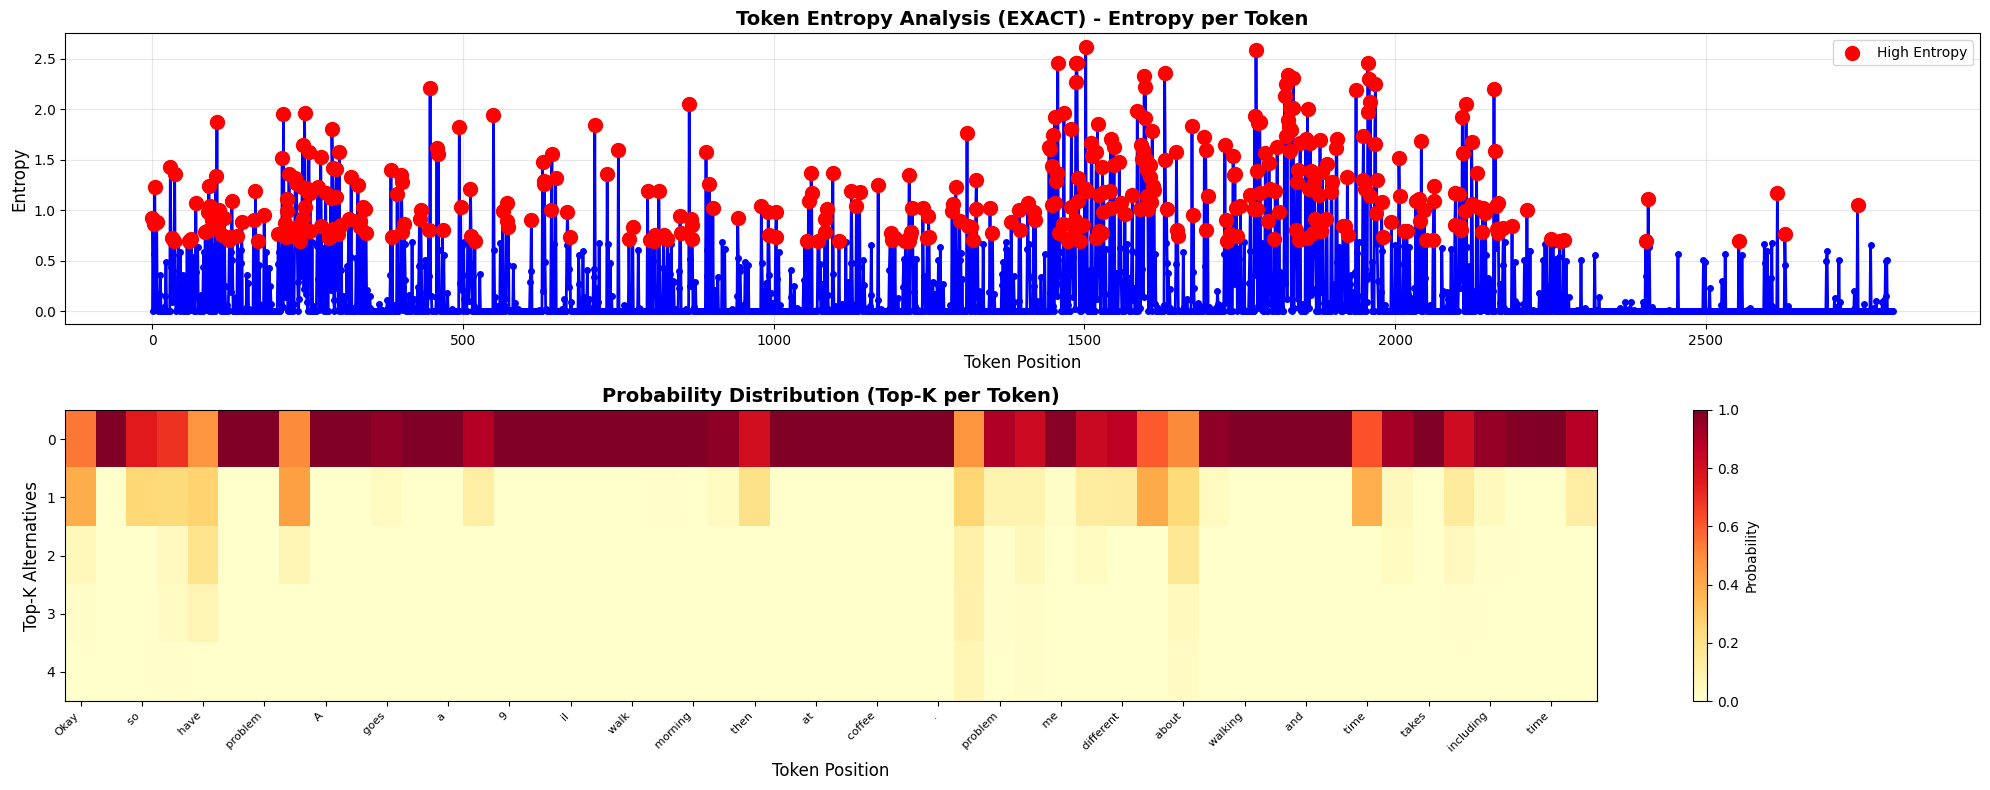

In [ ]:
# Tính EXACT entropy over full vocab với hàm mới (GPU-optimized)
scores = torch.stack(outputs.scores, dim=0)  # (T, B, V)

entropies = calculate_token_entropy_transformers(
    scores=scores,
    tokenizer=tokenizer,
    output_tokens=output_tokens,
    top_k_display=5
)

print(f"✓ Calculated entropy for {len(entropies)} tokens")
print(f"Probability coverage: {entropies[0]['prob_coverage']:.4f} (exact)")
print(f"Vocab size used: {entropies[0]['num_tokens_used']}")

# Visualize entropy
fig = visualize_entropy(entropies, title="Token Entropy Analysis (EXACT)")
plt.show()

In [24]:
# Print chi tiết top-10 tokens với entropy cao nhất
print_token_details(entropies, top_n=10)

# Visualize tokens với màu sắc theo entropy (giống như trong ảnh)
print("\n" + "="*80)
print("Token-by-Token Visualization with Entropy Coloring")
print("="*80)


Top 10 Tokens by Entropy

1. Position 1502: '' found'' (Entropy: 2.6231)
   Top alternatives:
      1. ' found' (prob: 0.2460, logprob: -1.4026)
      2. ' we' (prob: 0.2164, logprob: -1.5307)
      3. ' s' (prob: 0.1069, logprob: -2.2356)
      4. ' when' (prob: 0.0624, logprob: -2.7737)
      5. ' solving' (prob: 0.0539, logprob: -2.9198)

2. Position 1776: '' that'' (Entropy: 2.5921)
   Top alternatives:
      1. ' that' (prob: 0.2962, logprob: -1.2166)
      2. ' all' (prob: 0.1637, logprob: -1.8095)
      3. ' when' (prob: 0.0865, logprob: -2.4478)
      4. ' yes' (prob: 0.0749, logprob: -2.5916)
      5. ' correct' (prob: 0.0572, logprob: -2.8608)

3. Position 1457: '' '' (Entropy: 2.4614)
   Top alternatives:
      1. ' ' (prob: 0.3226, logprob: -1.1314)
      2. ' when' (prob: 0.2122, logprob: -1.5502)
      3. ' s' (prob: 0.0824, logprob: -2.4967)
      4. ' no' (prob: 0.0434, logprob: -3.1371)
      5. ' in' (prob: 0.0400, logprob: -3.2191)

4. Position 1956: '' check'' (Ent

/tmp/ipykernel_27/1394277507.py:329: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


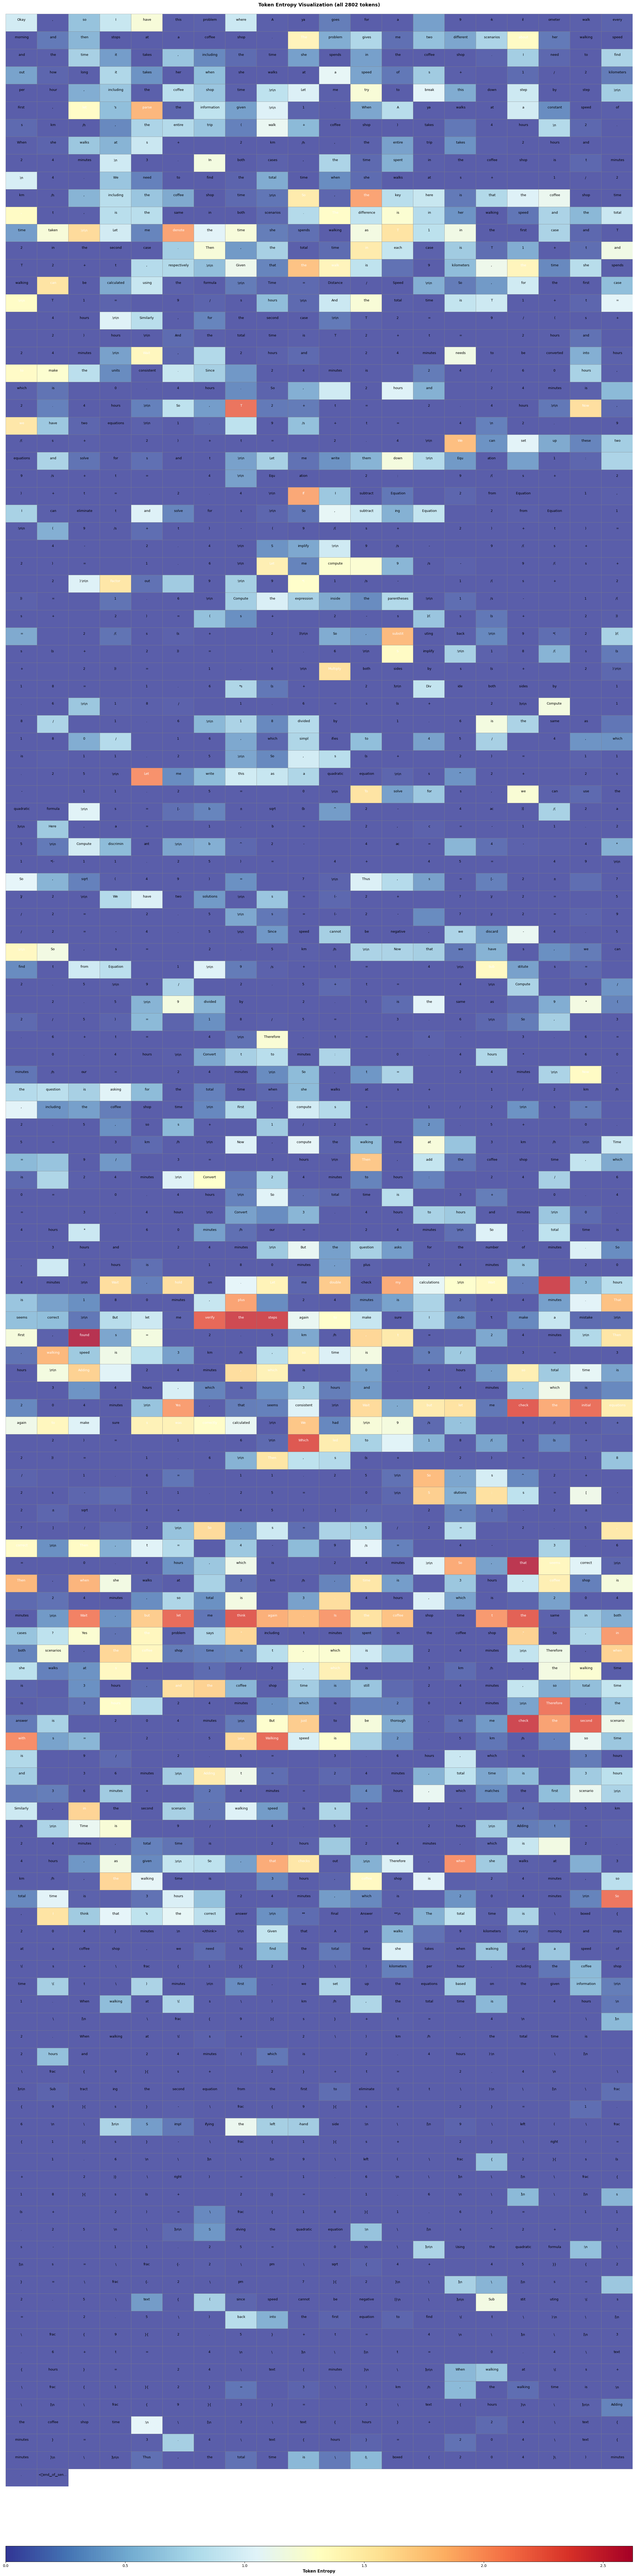

In [25]:
# Visualize all tokens
fig = visualize_tokens_with_entropy(
    entropies,
    start_idx=0,
    end_idx=None,  # None = hiển thị hết
    tokens_per_row=20,  # 20 tokens per row để fit screen
    show_entropy_values=False  # Set True nếu muốn hiển thị giá trị entropy
)
plt.show()


## Example 2: Attention Visualization (dùng output từ Example 1)


In [26]:
# Sử dụng output từ Example 1 (Cell 13) - không cần generate lại
# outputs variable đã tồn tại từ cell 13

print("✓ Using generated output from Example 1 (Cell 13)")
print(f"Number of generated tokens: {len(outputs.scores)}")
print(f"Sequences shape: {outputs.sequences.shape}")


✓ Using generated output from Example 1 (Cell 13)
Number of generated tokens: 2802
Sequences shape: torch.Size([1, 2942])


In [28]:
# Forward pass để lấy attentions
# Lấy full sequence (input + generated từ Example 1)
full_sequence = outputs.sequences  # Shape: (batch_size, total_seq_len)

print(f"Full sequence length: {full_sequence.shape[1]} tokens")

# Forward pass với full sequence để lấy attentions
print("Running forward pass to get attentions...")
with torch.no_grad():
    model.config._attn_implementation = "eager"
    model.config.output_attentions = True
    forward_outputs = model(
        input_ids=full_sequence,
        output_attentions=True,
        return_dict=True
    )

print(f"✓ Forward pass complete")
print(f"Attentions:")
print(f"  - Number of layers: {len(forward_outputs.attentions)}")
print(f"  - Layer 0 attention shape: {forward_outputs.attentions[0].shape}")
print(f"  - Format: (batch_size, num_heads, seq_len, seq_len)")


Full sequence length: 2942 tokens
Running forward pass to get attentions...
✓ Forward pass complete
Attentions:
  - Number of layers: 28
  - Layer 0 attention shape: torch.Size([1, 28, 2942, 2942])
  - Format: (batch_size, num_heads, seq_len, seq_len)


In [29]:
# Chuẩn bị data cho visualization
attentions_to_use = forward_outputs.attentions

# Decode tokens cho labeling
generated_ids = outputs.sequences[0]
generated_tokens = [tokenizer.decode([tok]) for tok in generated_ids]

print(f"Total tokens in sequence: {len(generated_tokens)}")
print(f"Attentions available for {len(attentions_to_use)} layers")


Total tokens in sequence: 2942
Attentions available for 28 layers


In [30]:
# Setup layers và heads để visualize
num_layers = model.config.num_hidden_layers
num_heads = model.config.num_attention_heads

print(f"Model has {num_layers} layers and {num_heads} attention heads per layer")

# Chọn layers và heads quan trọng để visualize
layers_heads = [
    (0, 0),                              # First layer, first head
    (num_layers // 2, 0),                # Middle layer, first head
    (num_layers // 2, num_heads // 2),   # Middle layer, middle head
    (num_layers - 1, 0),                 # Last layer, first head
    (num_layers - 1, num_heads // 2),    # Last layer, middle head
    (num_layers - 1, num_heads - 1),     # Last layer, last head
]

print(f"Will visualize layers/heads: {layers_heads}")


Model has 28 layers and 28 attention heads per layer
Will visualize layers/heads: [(0, 0), (14, 0), (14, 14), (27, 0), (27, 14), (27, 27)]


/tmp/ipykernel_27/1793272141.py:84: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


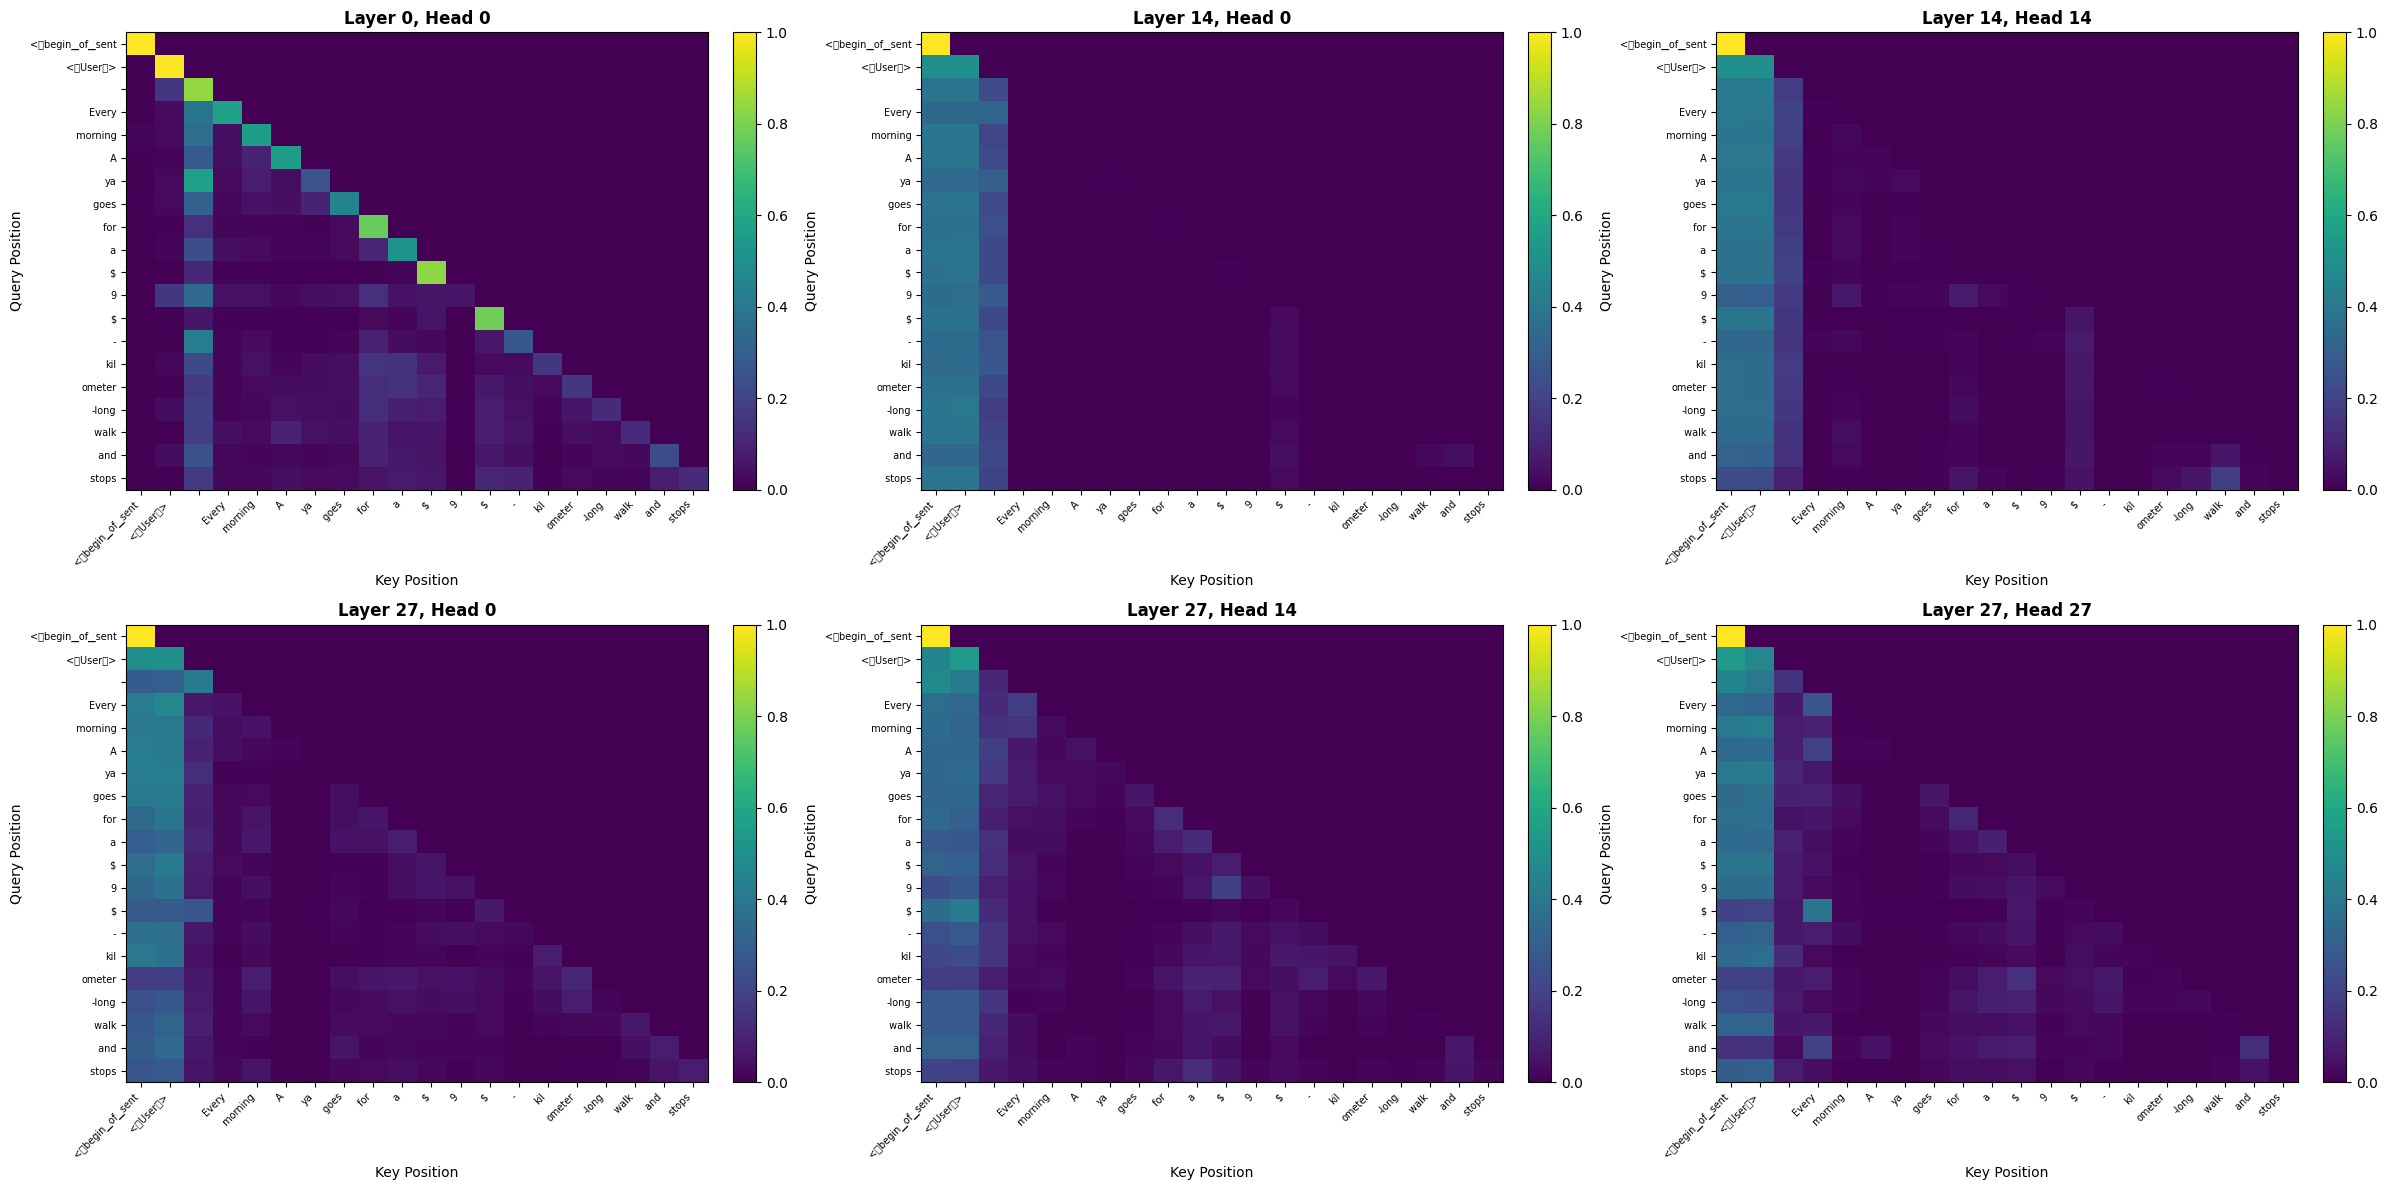

In [39]:
# Visualize attention heatmaps
fig = visualize_attention(
    attentions_to_use,
    layers_heads=layers_heads,
    tokens=generated_tokens,
    max_tokens_display=20,
    figsize_per_plot=(8, 6)
)
plt.show()


/tmp/ipykernel_27/1394277507.py:62: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


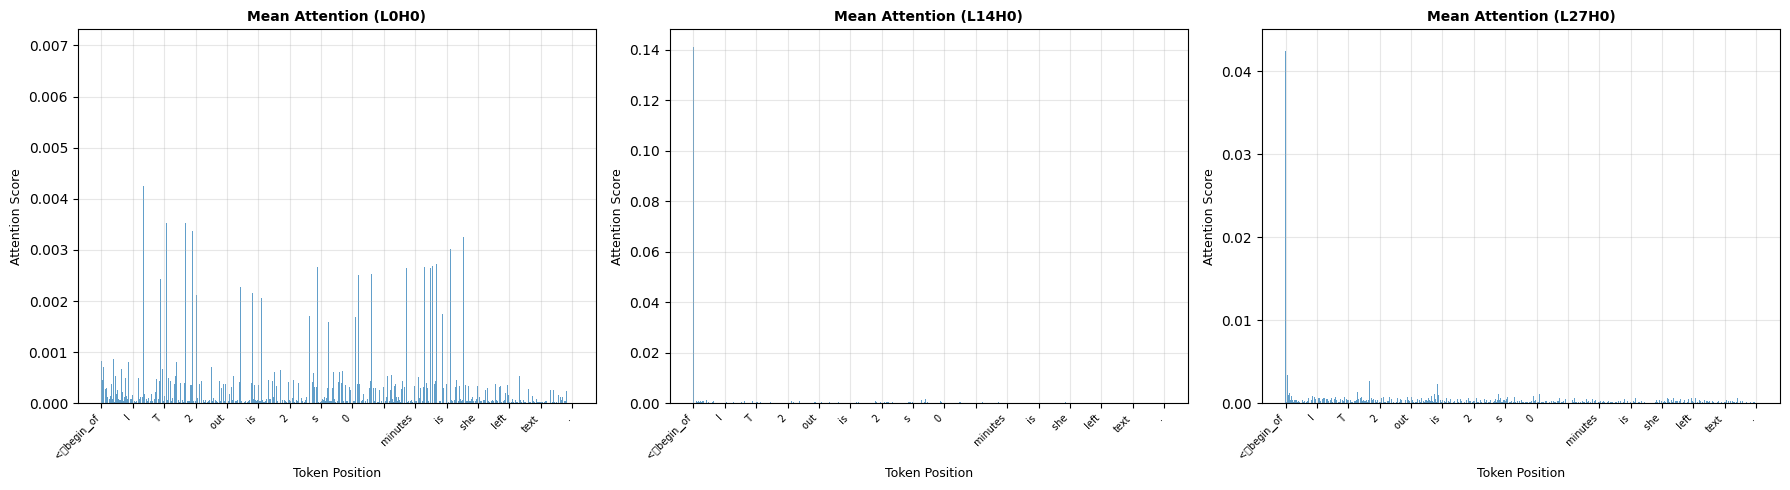

In [32]:
# Visualize mean attention patterns
fig = visualize_attention_patterns(
    attentions_to_use,
    layers_heads=[(0, 0), (num_layers // 2, 0), (num_layers - 1, 0)],
    tokens=generated_tokens,
    pattern_type='mean',
    figsize=(18, 5)
)
plt.show()

/tmp/ipykernel_27/1394277507.py:62: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


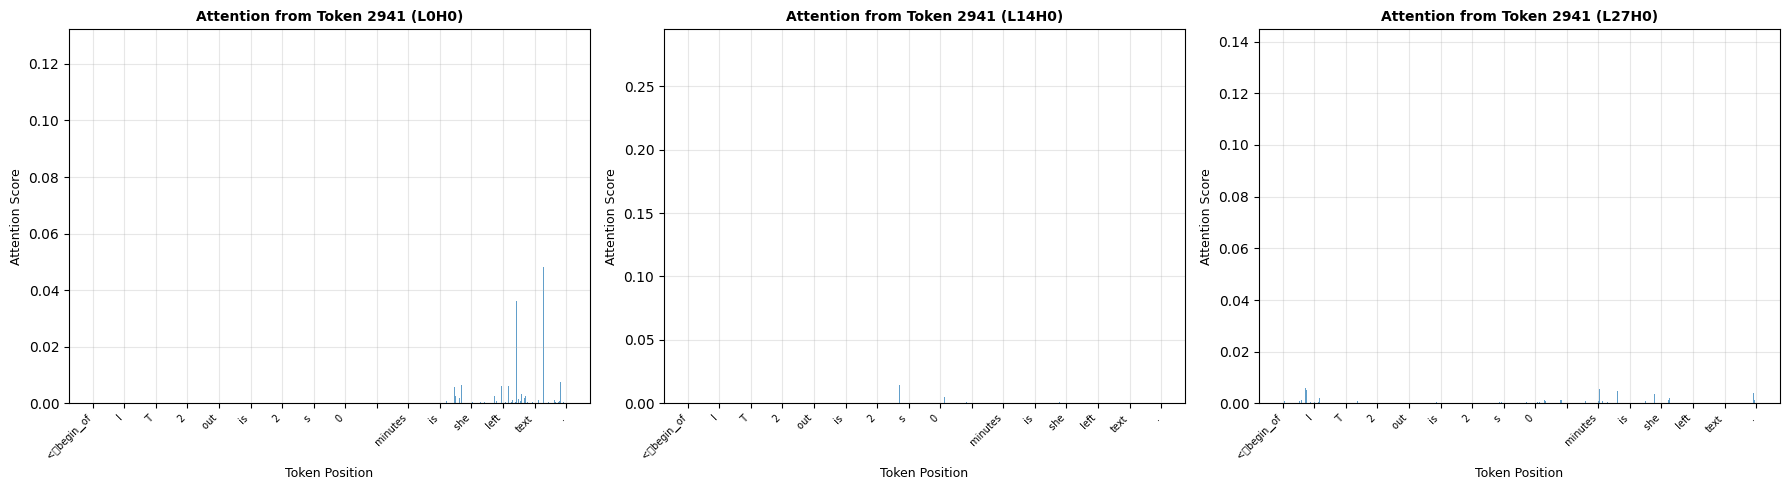

In [33]:
# Visualize attention từ một token cụ thể (ví dụ: token cuối cùng)
last_token_idx = len(generated_tokens) - 1
fig = visualize_attention_patterns(
    attentions_to_use,
    layers_heads=[(0, 0), (num_layers // 2, 0), (num_layers - 1, 0)],
    tokens=generated_tokens,
    pattern_type='specific_token',
    token_idx=last_token_idx,
    figsize=(18, 5)
)
plt.show()


Visualizing layers: [0, 1, 2, 9, 14, 18, 27]


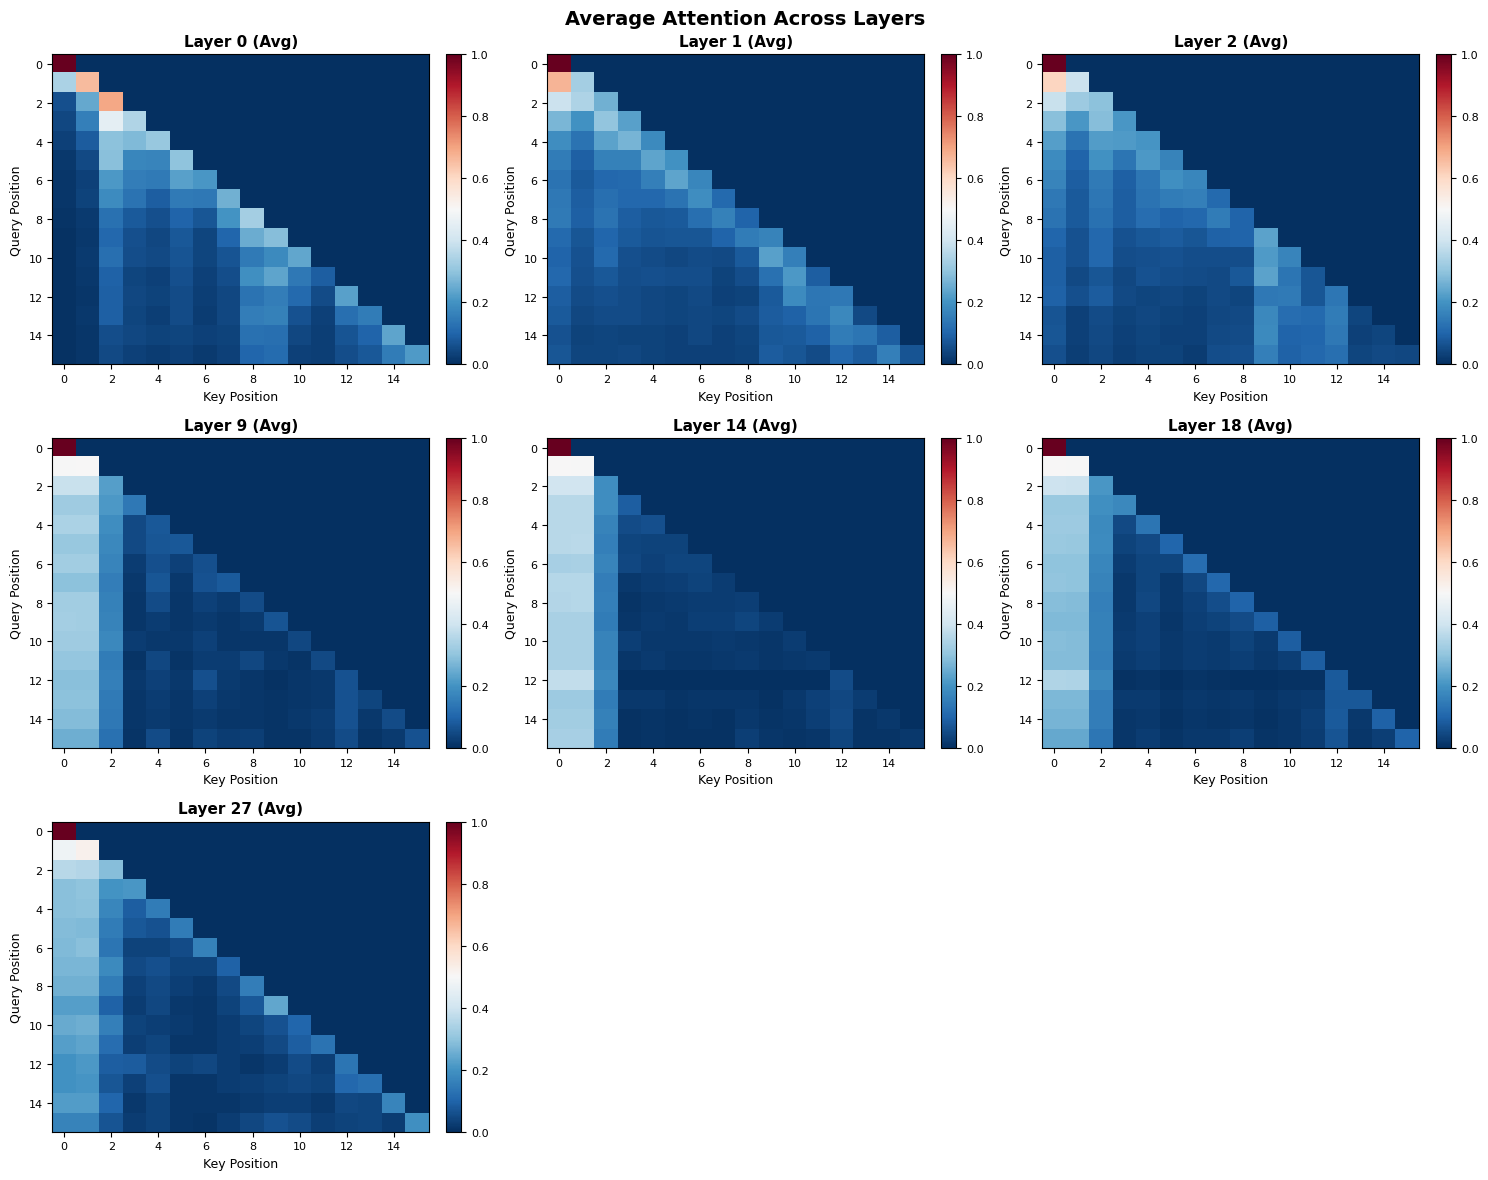

In [34]:
# Visualize attention cho nhiều layers (style như paper)
# Giống như Figure 2 trong paper: hiển thị attention patterns across layers

# Chọn các layers quan trọng để visualize
selected_layers = [0, 1, 2, num_layers // 3, num_layers // 2, 2*num_layers // 3, num_layers - 1]
print(f"Visualizing layers: {selected_layers}")

# Option 1: Average attention across all heads
fig = visualize_attention_layers(
    attentions_to_use,
    layer_indices=selected_layers,
    head_idx=None,  # None = average across all heads
    max_tokens_display=16,  # Giống như trong hình (16 tokens)
    cmap='RdBu_r',  # Red = high attention, Blue = low attention
    title='Average Attention Across Layers'
)
plt.show()


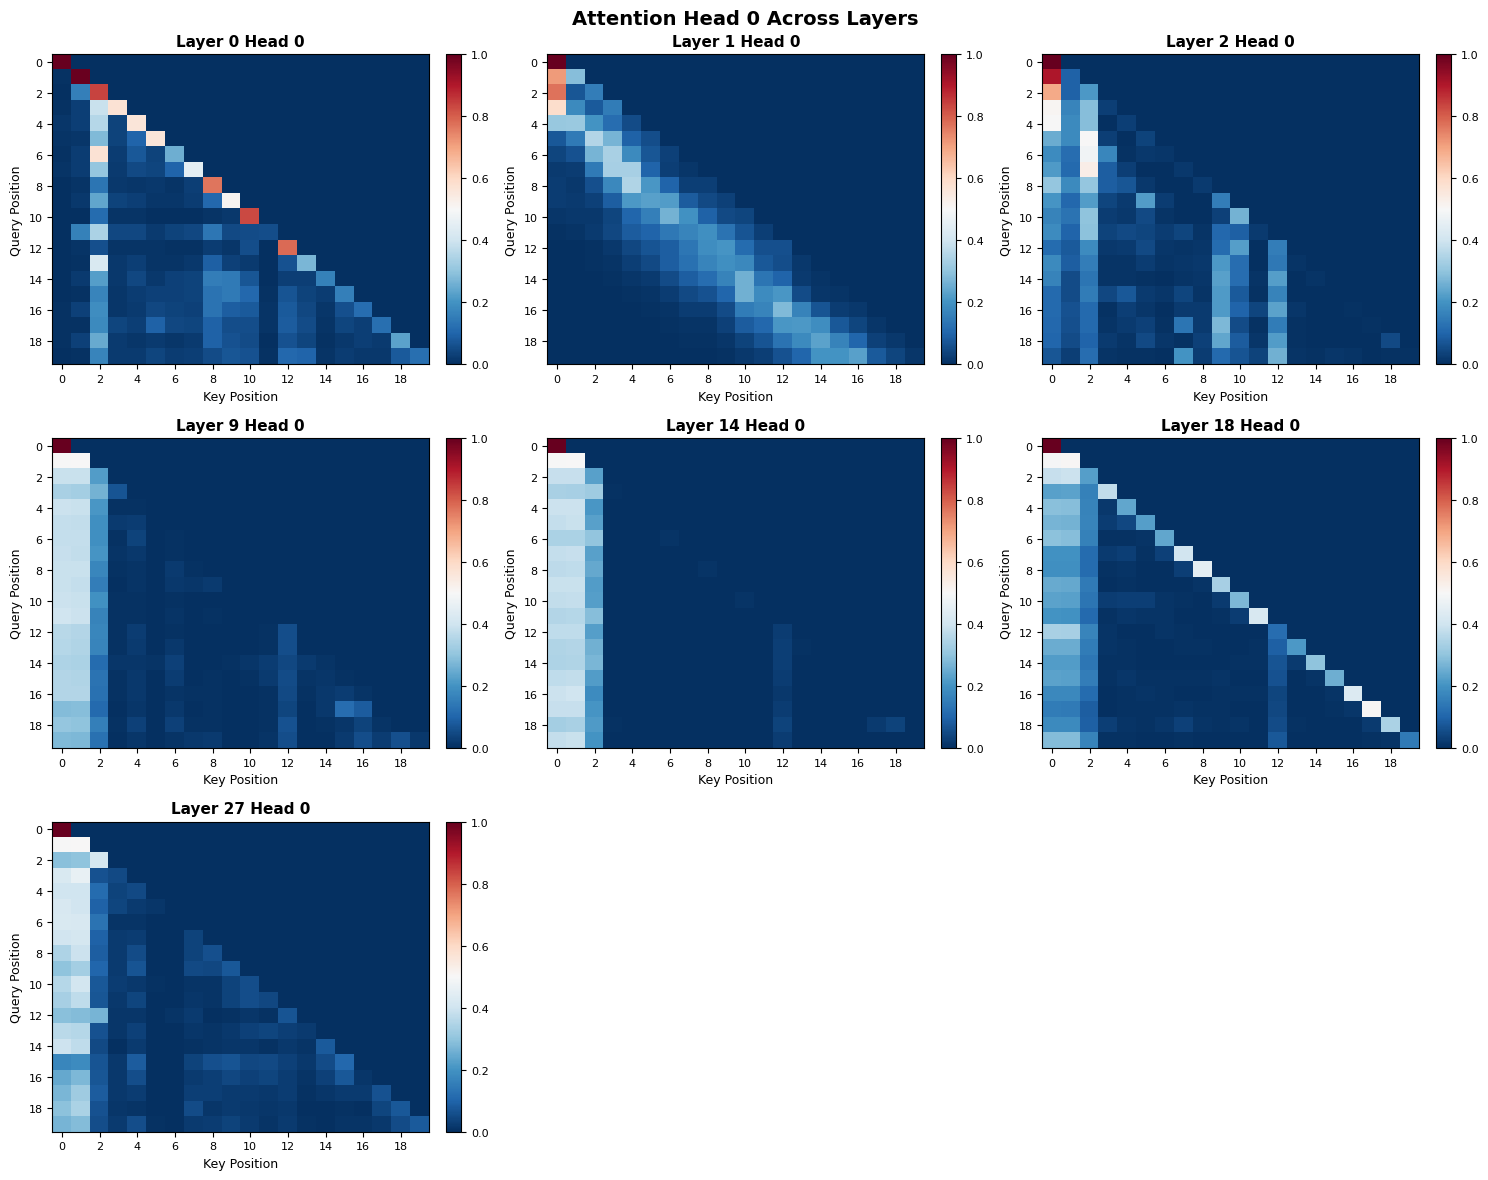

In [35]:
# Option 2: Visualize specific head (head 0) across layers
fig = visualize_attention_layers(
    attentions_to_use,
    layer_indices=selected_layers,
    head_idx=0,  # Specific head
    max_tokens_display=20,
    cmap='RdBu_r',
    title=f'Attention Head 0 Across Layers'
)
plt.show()


## 🔍 Bonus: Analyze Attention Around High Entropy Tokens

**High entropy tokens** = tokens where model không chắc chắn (nhiều alternatives tốt)
→ Thường là decision points, reasoning transitions, hoặc critical information

Bây giờ ta sẽ:
1. Identify high entropy tokens
2. Visualize attention patterns xung quanh chúng
3. Understand what the model attends to when uncertain


📊 Visualization settings:
   Input length: 140
   Total tokens: 2942
   Output tokens: 2802

Found 5 high entropy tokens (in OUTPUT)
Input length: 140, Total tokens: 2942

1. Output pos 1457 (Full pos 1597): ' ' (Entropy: 2.4614)
2. Output pos 1487 (Full pos 1627): ' the' (Entropy: 2.4591)
3. Output pos 1502 (Full pos 1642): ' found' (Entropy: 2.6231)
4. Output pos 1776 (Full pos 1916): ' that' (Entropy: 2.5921)
5. Output pos 1956 (Full pos 2096): ' check' (Entropy: 2.4610)


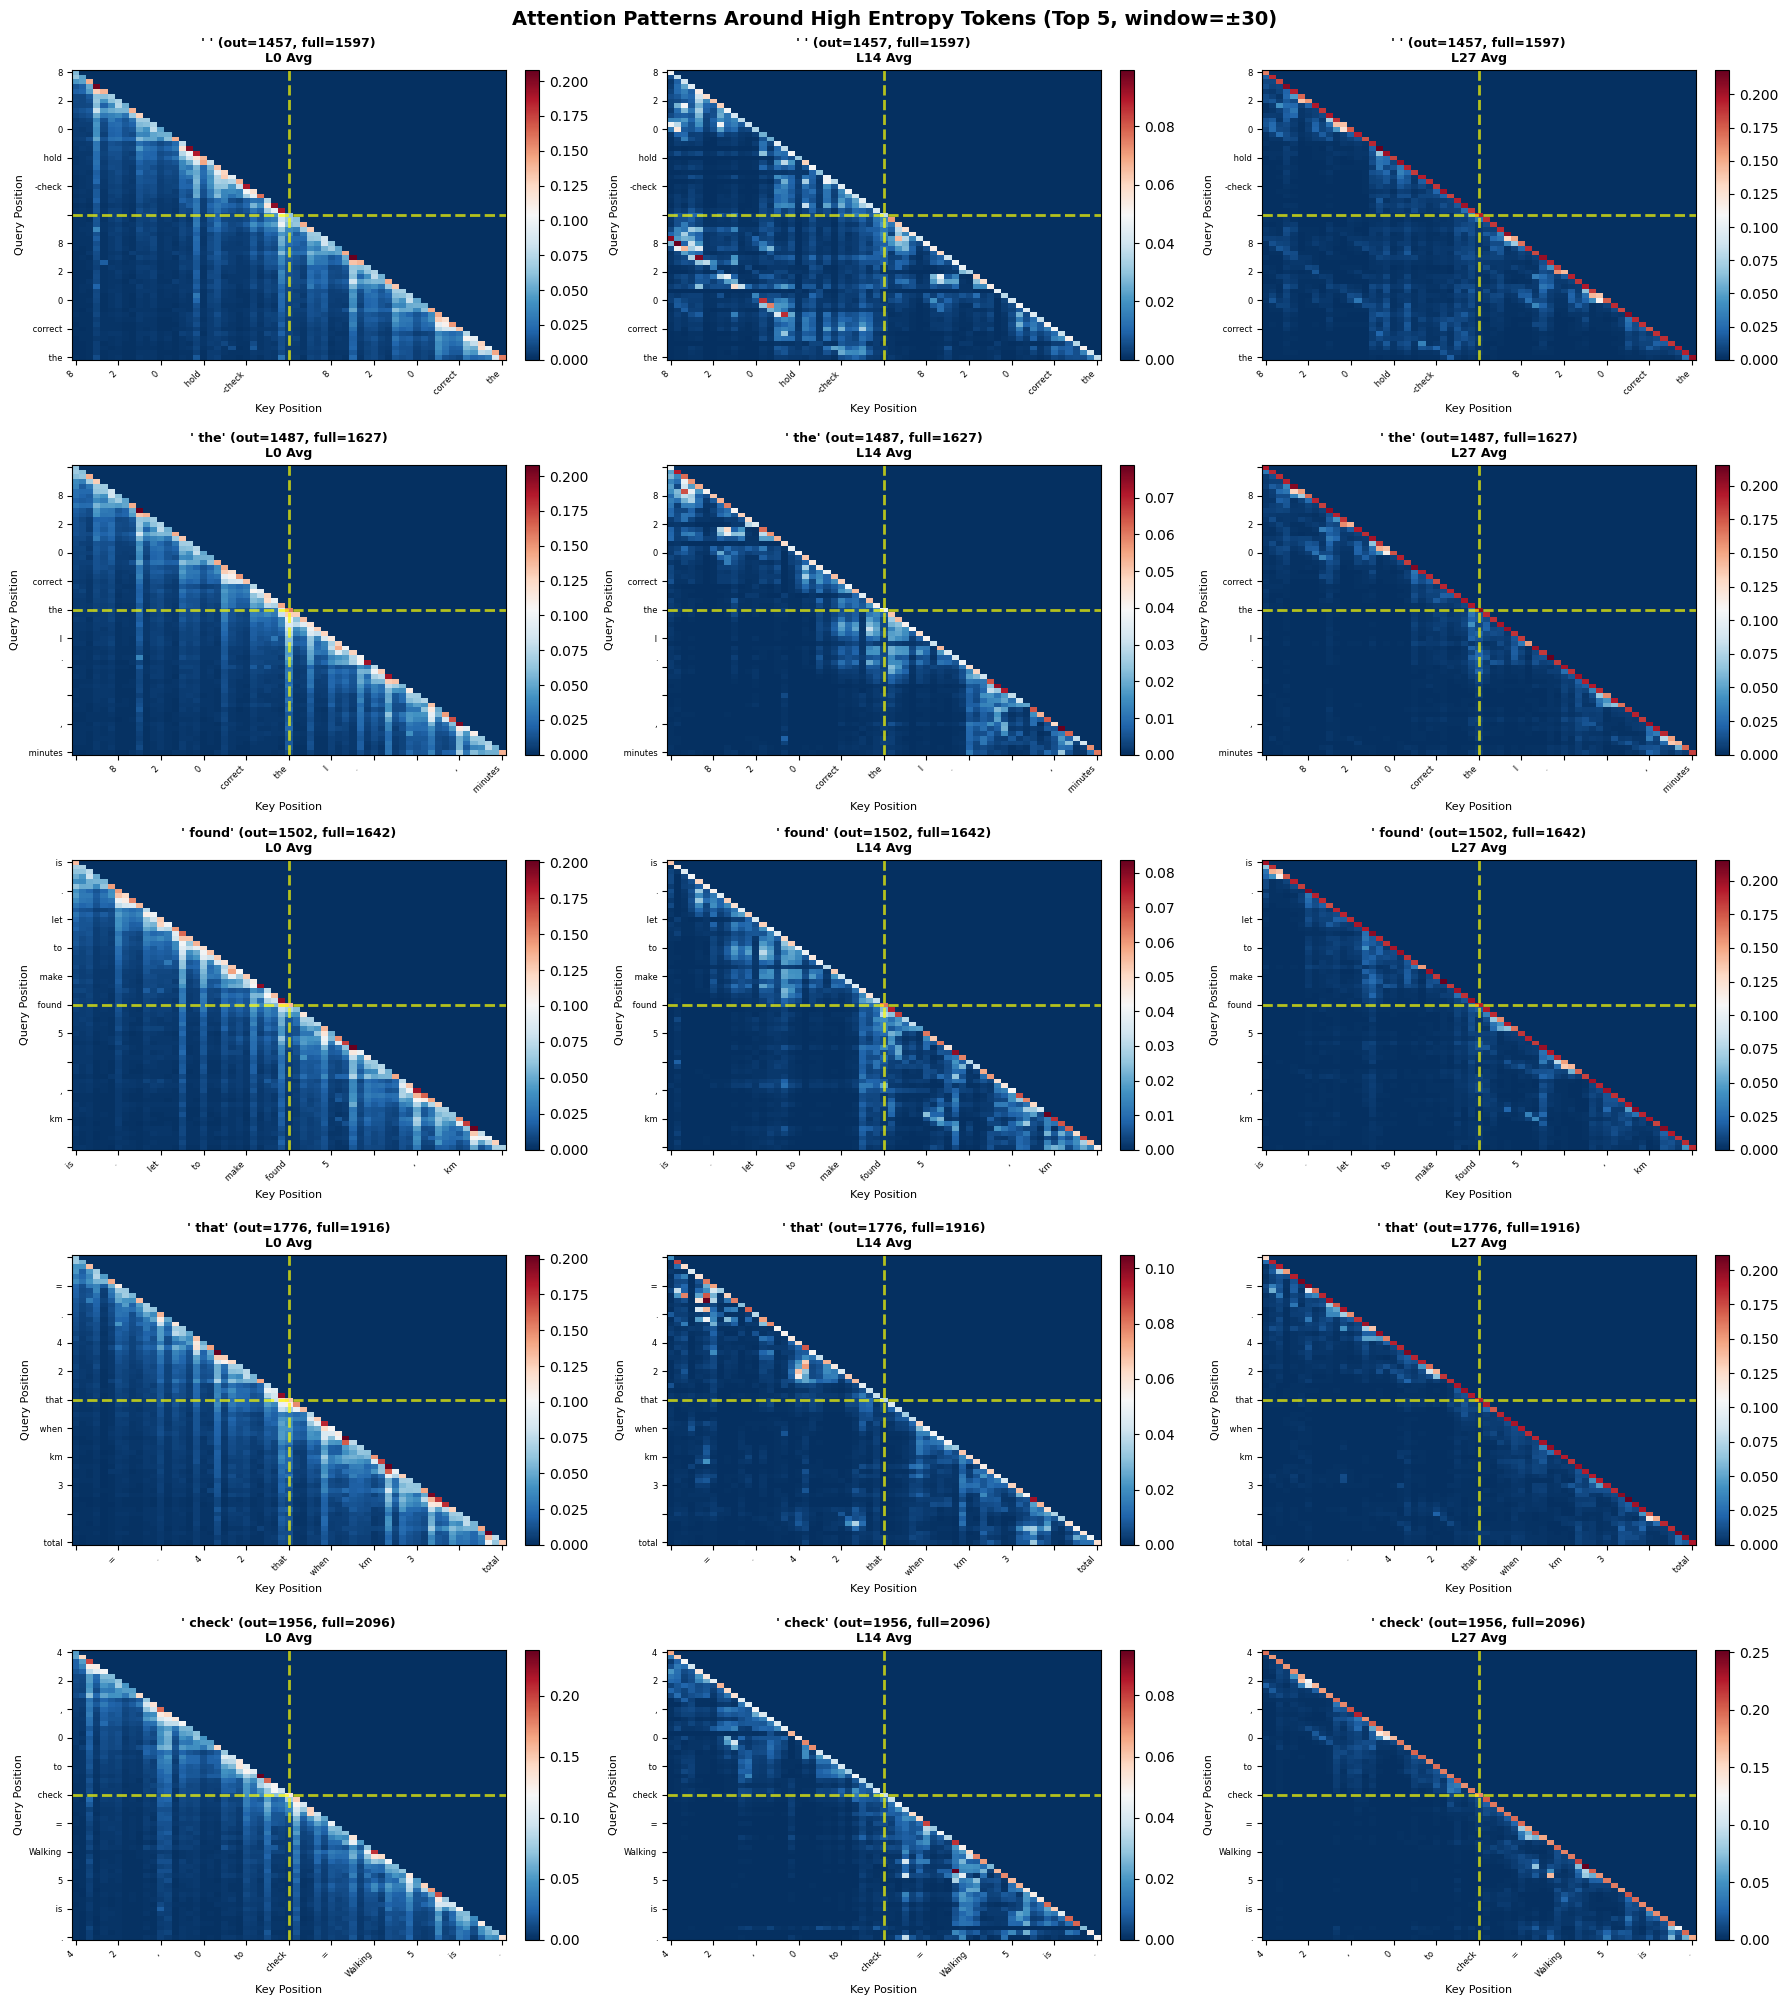

In [46]:
# Bạn cần có cả entropies VÀ attentions từ Examples trước
# entropies: từ Example 1 (cell 16)
# attentions_to_use: từ Example 2 (cell 22)
# generated_tokens: từ Example 2 (cell 22)

# Get input length for position offset
input_length = inputs.input_ids.shape[1]

print(f"📊 Visualization settings:")
print(f"   Input length: {input_length}")
print(f"   Total tokens: {len(generated_tokens)}")
print(f"   Output tokens: {len(entropies)}")

# Option 1: Analyze top 5 highest entropy tokens
high_entropy_tokens, fig = visualize_attention_around_high_entropy(
    attention_weights=attentions_to_use,
    entropies=entropies,
    tokens=generated_tokens,
    input_length=input_length,  # ← CRITICAL for position offset
    threshold_method='top_k',
    k=5,  # Top 5 tokens
    layer_indices=[0, 14, 27],  # First, middle, last layers
    head_idx=None,  # Average all heads
    context_window=30,  # Show ±50 tokens (100 total) - INCREASED!
    figsize=None  # Auto
)
plt.show()



Found 400 high entropy tokens

1. Position 0: 'Okay' (Entropy: 0.9229)
2. Position 3: ' I' (Entropy: 0.8670)
3. Position 4: ' have' (Entropy: 1.2299)
4. Position 7: ' where' (Entropy: 0.8859)
5. Position 29: ' The' (Entropy: 1.4306)
6. Position 31: ' gives' (Entropy: 0.7236)
7. Position 35: ' scenarios' (Entropy: 0.6987)
8. Position 36: ' about' (Entropy: 1.3564)
9. Position 59: ' find' (Entropy: 0.6962)
10. Position 63: ' it' (Entropy: 0.7182)


/tmp/ipykernel_27/2830181862.py:193: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


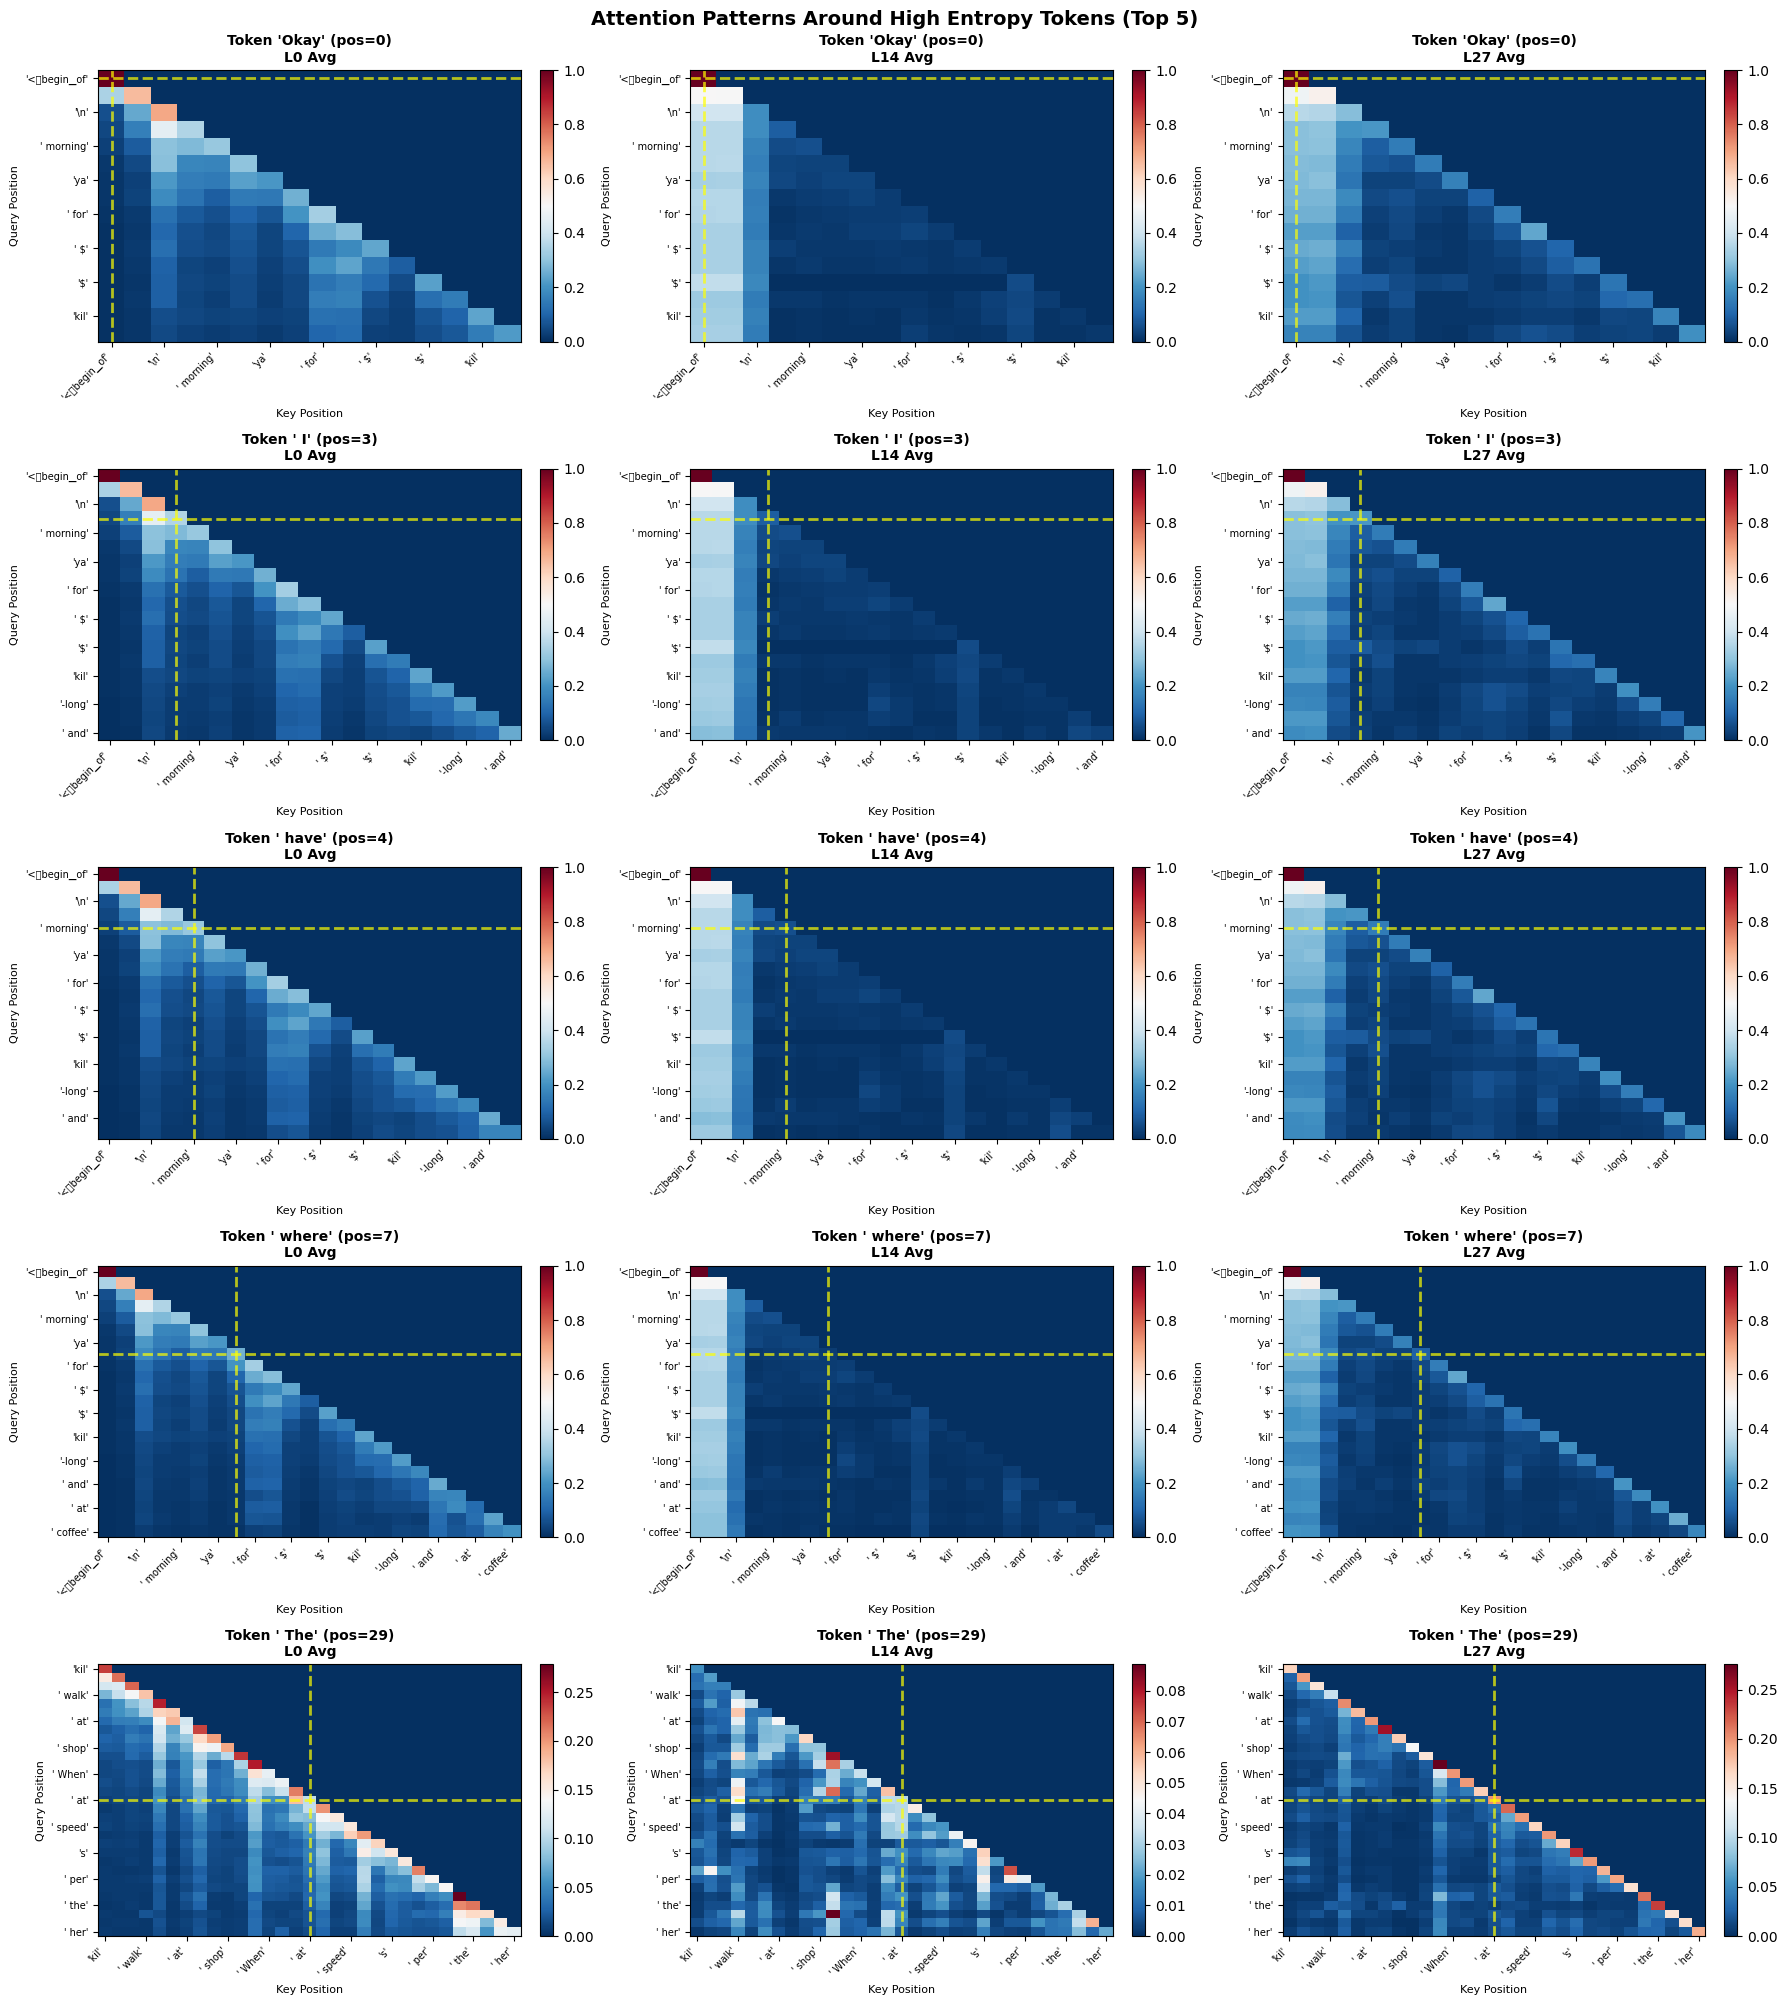


📊 Comparison:
Top-k method found: 10 tokens
Std method found: 400 tokens


In [ ]:
# Option 2: Analyze tokens above mean + 1 std (statistical threshold)
high_entropy_tokens_std, fig = visualize_attention_around_high_entropy(
    attention_weights=attentions_to_use,
    entropies=entropies,
    tokens=generated_tokens,
    threshold_method='std',
    # std_multiplier=1.0,  # mean + 1*std
    layer_indices=[0, 14, 27],
    head_idx=None,
    context_window=15,  # Larger context window
    figsize=None
)
plt.show()
print(f"\n📊 Comparison:")
print(f"Top-k method found: {len(high_entropy_tokens)} tokens")
print(f"Std method found: {len(high_entropy_tokens_std)} tokens")


In [38]:
# Advanced: Get high entropy tokens only (without visualization)
high_ent_tokens = get_high_entropy_tokens(
    entropies,
    threshold_method='top_k',
    k=10
)

print("\n📍 Top 10 High Entropy Tokens:")
print("="*80)
for i, het in enumerate(high_ent_tokens, 1):
    print(f"{i}. Position {het['position']:4d}: '{het['token']}' (Entropy: {het['entropy']:.4f})")
    # Show top alternatives
    print(f"   Alternatives:")
    for j, (alt_token, logprob) in enumerate(het['top_alternatives'][:3], 1):
        prob = het['top_probs'][j-1]
        print(f"      {j}. '{alt_token}' (p={prob:.3f})")
    print()

# Analyze entropy distribution
entropy_values = [e['entropy'] for e in entropies]
print(f"\n📊 Entropy Statistics:")
print(f"   Mean:   {np.mean(entropy_values):.4f}")
print(f"   Median: {np.median(entropy_values):.4f}")
print(f"   Std:    {np.std(entropy_values):.4f}")
print(f"   Min:    {np.min(entropy_values):.4f}")
print(f"   Max:    {np.max(entropy_values):.4f}")
print(f"   95th:   {np.percentile(entropy_values, 95):.4f}")



📍 Top 10 High Entropy Tokens:
1. Position 1457: ' ' (Entropy: 2.4614)
   Alternatives:
      1. ' ' (p=0.323)
      2. ' when' (p=0.212)
      3. ' s' (p=0.082)

2. Position 1487: ' the' (Entropy: 2.4591)
   Alternatives:
      1. ' the' (p=0.243)
      2. ' all' (p=0.233)
      3. ' if' (p=0.103)

3. Position 1488: ' steps' (Entropy: 2.4562)
   Alternatives:
      1. ' steps' (p=0.351)
      2. ' initial' (p=0.187)
      3. ' earlier' (p=0.080)

4. Position 1502: ' found' (Entropy: 2.6231)
   Alternatives:
      1. ' found' (p=0.246)
      2. ' we' (p=0.216)
      3. ' s' (p=0.107)

5. Position 1596: ' check' (Entropy: 2.3323)
   Alternatives:
      1. ' check' (p=0.275)
      2. ' just' (p=0.125)
      3. ' make' (p=0.104)

6. Position 1629: 'Which' (Entropy: 2.3625)
   Alternatives:
      1. 'Which' (p=0.200)
      2. 'We' (p=0.198)
      3. 'With' (p=0.185)

7. Position 1776: ' that' (Entropy: 2.5921)
   Alternatives:
      1. ' that' (p=0.296)
      2. ' all' (p=0.164)
      3. '